In [26]:
# !pip install keras-core --upgrade
# !pip install -q keras-nlp
# !pip install seaborn

In [27]:
# !pip install transformers

# Import the Libararies

In [28]:
# !pip install pandas

In [29]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
# import keras_core as keras
# import keras_nlp
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
print("TensorFlow version:", tf.__version__)
# print("Keras version:", keras.__version__)
# print("KerasNLP version:", keras_nlp.__version__)

TensorFlow version: 2.7.0


# Load the data


In [30]:
train_prompts = pd.read_csv('train_prompts.csv') #('/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv')
train_essays = pd.read_csv('train_essays.csv')#('/kaggle/input/llm-detect-ai-generated-text/train_essays.csv')
test_essays = pd.read_csv('test_essays.csv')#('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')
train_extra = pd.read_csv('train_v3_drcat_01.csv')#('/kaggle/input/daigt-v3-train-dataset/train_v3_drcat_01.csv')
train_extra_2 = pd.read_csv('train_v3_drcat_02.csv')#('/kaggle/input/daigt-v3-train-dataset/train_v3_drcat_02.csv')

# 🐝 **데이터 분석 및 증강**

In [31]:
df_train_extra=pd.concat([train_extra,train_extra_2],ignore_index=True)


Text(0.5, 1.0, 'Distribution of prompt ID')

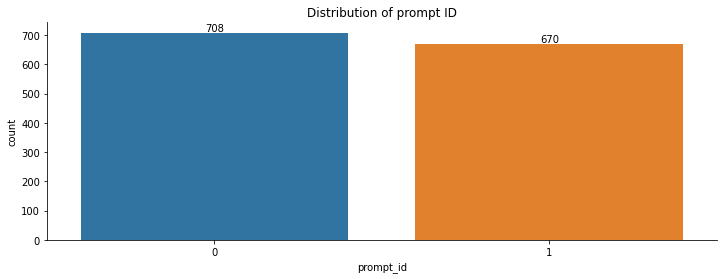

In [32]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=train_essays,
                   x="prompt_id")

abs_values = train_essays['prompt_id'].value_counts().values

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of prompt ID")

Text(0.5, 1.0, 'Distribution of Generated Text')

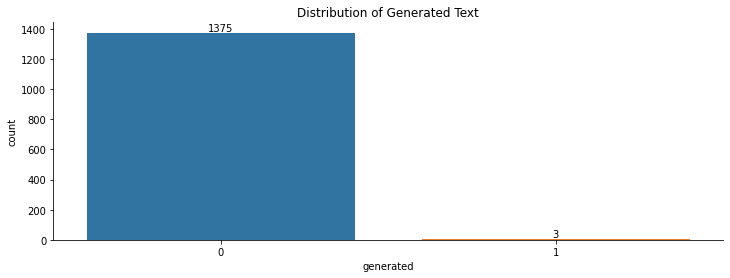

In [33]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=train_essays,
                   x="generated")

abs_values = train_essays['generated'].value_counts().values

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of Generated Text")

In [34]:
df_train_extra.rename(columns = {"label":"generated"}, inplace=True)

In [35]:
df_train_extra.head()

,text,generated,prompt_name,source,RDizzl3_seven,model
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False,NaN
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False,NaN
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False,NaN
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False,NaN
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False,NaN


Text(0.5, 1.0, 'Distribution of Generated Text')

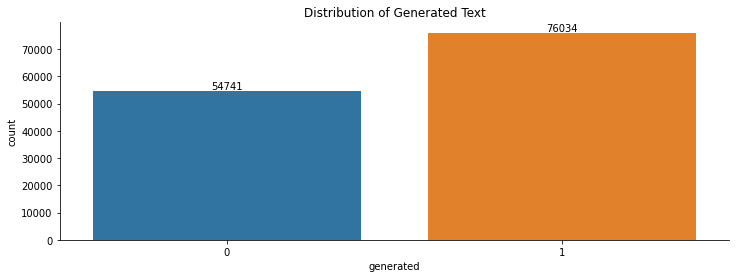

In [36]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=df_train_extra,
                   x="generated")

abs_values = df_train_extra['generated'].value_counts(sort=False).values

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of Generated Text")

In [37]:
df_train_essays_final = pd.concat([df_train_extra[["text", "generated"]], train_essays[["text", "generated"]]])

df_train_essays_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132153 entries, 0 to 1377
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   text       132005 non-null  object
 1   generated  132153 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.0+ MB


In [38]:
df_train_essays_final.isna().sum()

text         148
generated      0
dtype: int64

In [39]:
df_train_essays_final.dropna(inplace=True)

In [40]:
df_train_essays_final = df_train_essays_final.drop_duplicates(subset=['text'])

df_train_essays_final.reset_index(drop=True, inplace=True)

Text(0.5, 1.0, 'Distribution of Generated Text')

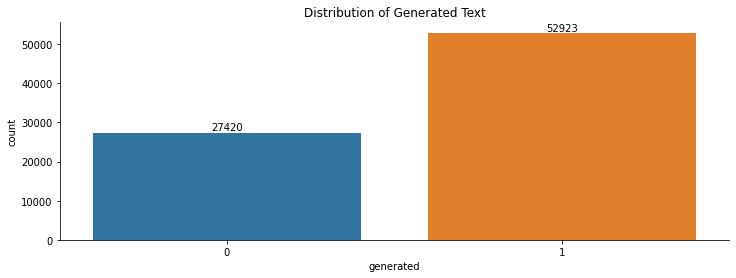

In [41]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=df_train_essays_final,
                   x="generated")


abs_values = df_train_essays_final['generated'].value_counts(sort=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)
ax.set_title("Distribution of Generated Text")

## 1) generated=0, student 생성 text label 데이터의 감소가 보임__ unbalance 해결 필요
## 2) 전처리된 train set의 text들이 훈련에 적절한 내용을 제대로 포함하고 있는지 확인 필요
## + GPU 메모리 부족현상을 극복

In [42]:
df_train_essays_final['text_length'] = df_train_essays_final['text'].apply(len)

# 'generated' 항목을 기준으로 0과 1로 데이터를 나눕니다.
generated_0 = df_train_essays_final[df_train_essays_final['generated'] == 0]
generated_1 = df_train_essays_final[df_train_essays_final['generated'] == 1]

# 데이터프레임에서 'text' 항목의 문장들을 추출합니다.
sentences_0 = generated_0['text'].tolist()
sentences_1 = generated_1['text'].tolist()

# 문장들의 길이를 측정합니다.
sentence_lengths_0 = [len(sentence.split()) for sentence in sentences_0]
sentence_lengths_1 = [len(sentence.split()) for sentence in sentences_1]

# 문장들의 길이가 50 이하인 요소들의 개수 확인
count_sentences_0_below_50 = sum(1 for length in sentence_lengths_0 if length <= 50)
count_sentences_1_below_50 = sum(1 for length in sentence_lengths_1 if length <= 50)

print("Count of 'generated' 0 with text length below 50:", count_sentences_0_below_50)
print("Count of 'generated' 1 with text length below 50:", count_sentences_1_below_50)


Count of 'generated' 0 with text length below 50: 3
Count of 'generated' 1 with text length below 50: 98


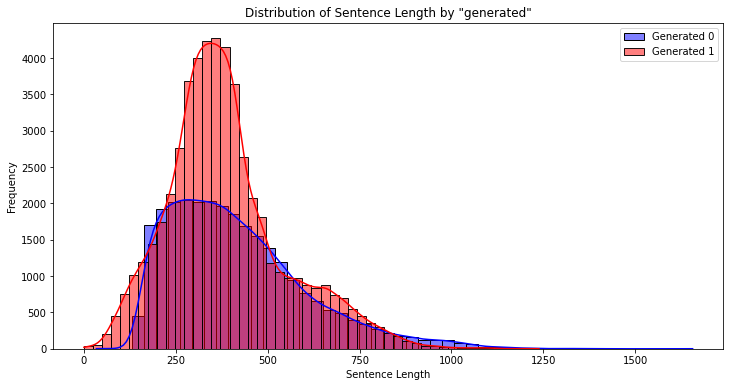

In [43]:
# 길이 분포 시각화
plt.figure(figsize=(12, 6))
sns.histplot(sentence_lengths_0, bins=50, color='blue', label='Generated 0', kde=True)
sns.histplot(sentence_lengths_1, bins=50, color='red', label='Generated 1', kde=True)
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Sentence Length by "generated"')
plt.show()


In [44]:
# 'generated' 항목을 기준으로 0과 1로 데이터를 나눕니다.
generated_0 = df_train_essays_final[df_train_essays_final['generated'] == 0]
generated_1 = df_train_essays_final[df_train_essays_final['generated'] == 1]

# 데이터프레임에서 'text' 항목의 문장들을 추출합니다.
sentences_0 = generated_0['text'].tolist()
sentences_1 = generated_1['text'].tolist()

# 문장들의 길이를 측정합니다.
sentence_lengths_0 = [len(sentence.split()) for sentence in sentences_0]
sentence_lengths_1 = [len(sentence.split()) for sentence in sentences_1]

# 50 이하인 항목들을 데이터프레임에서 제거하고 새로운 데이터프레임 생성
generated_0 = generated_0[[(length > 50) for length in sentence_lengths_0]]
generated_1 = generated_1[[(length > 50) for length in sentence_lengths_1]]

# 다시 문장들의 길이를 측정
sentence_lengths_0 = [len(sentence.split()) for sentence in generated_0['text']]
sentence_lengths_1 = [len(sentence.split()) for sentence in generated_1['text']]

# 문장들의 길이가 50 이하인 요소들의 개수 확인
count_sentences_0_below_50 = len(sentences_0) - len(generated_0)
count_sentences_1_below_50 = len(sentences_1) - len(generated_1)

print("Count of 'generated' 0 with text length below 50:", count_sentences_0_below_50)
print("Count of 'generated' 1 with text length below 50:", count_sentences_1_below_50)


Count of 'generated' 0 with text length below 50: 3
Count of 'generated' 1 with text length below 50: 98


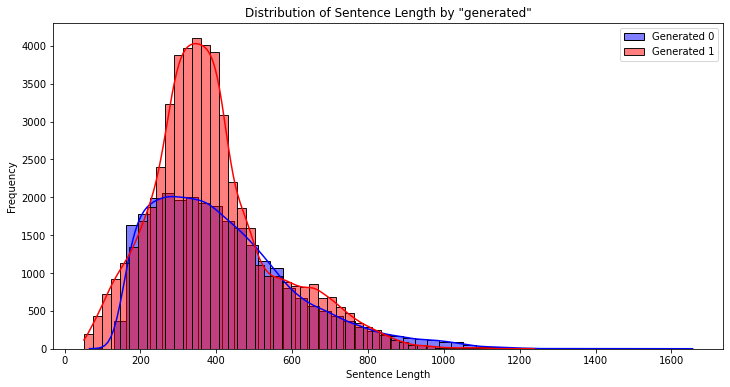

In [45]:
plt.figure(figsize=(12, 6))
sns.histplot(sentence_lengths_0, bins=50, color='blue', label='Generated 0', kde=True)
sns.histplot(sentence_lengths_1, bins=50, color='red', label='Generated 1', kde=True)
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Sentence Length by "generated"')
plt.show()

In [46]:
df_train_essays_final = pd.concat([generated_0[["text", "generated"]], generated_1[["text", "generated"]]])

df_train_essays_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80242 entries, 0 to 80342
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       80242 non-null  object
 1   generated  80242 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ MB


In [47]:
# Filter out the entries where 'generated' is 1.
generated_ones = df_train_essays_final[df_train_essays_final['generated'] == 1]

# Sort the filtered data by the length of the 'text' column, descending.
sorted_generated_ones = generated_ones.assign(text_length=generated_ones['text'].apply(len)).sort_values(by='text_length', ascending=True)

# Select the top 27420 entries with the longest text.
reduced_generated_ones = sorted_generated_ones.head(10000)



# Filter out the entries where 'generated' is 0.
generated_ones0 = df_train_essays_final[df_train_essays_final['generated'] == 0]

# Sort the filtered data by the length of the 'text' column, descending.
sorted_generated_ones0 = generated_ones0.assign(text_length=generated_ones0['text'].apply(len)).sort_values(by='text_length', ascending=True)

# Select the top 27420 entries with the longest text.
reduced_generated_ones0 = sorted_generated_ones0.head(10000)




# Combine the reduced set with the entries where 'generated' is 0.
reduced_df = pd.concat([reduced_generated_ones0, reduced_generated_ones])

# Remove the 'text_length' column used for sorting.
df_train_essays_final = reduced_df.drop(columns=['text_length'])

# Check the number of entries in the reduced dataset and show the first few entries.
df_train_essays_final.reset_index(drop=True, inplace=True)
len(df_train_essays_final), df_train_essays_final.head()


(20000,
                                                 text  generated
 0  A student presents their self-designed science...          0
 1  The Face on Mar's is just a natural landform b...          0
 2  For many years, people have been debating whet...          0
 3  Making Mona Lisa Smile\n\nIn the article " Mak...          0
 4  According to the article " Unmasking the Face ...          0)

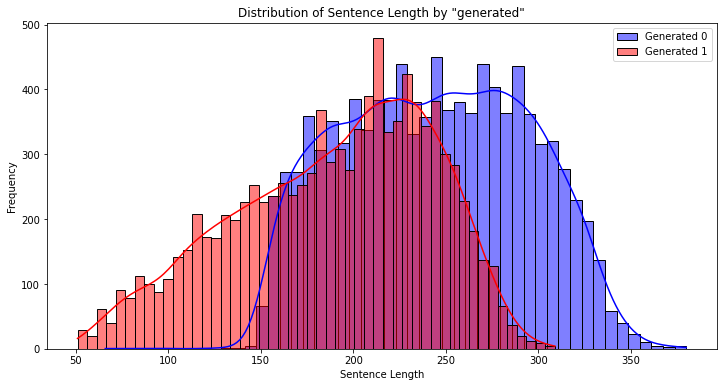

In [48]:
# 'generated' 항목을 기준으로 0과 1로 데이터를 나눕니다.
generated_0 = df_train_essays_final[df_train_essays_final['generated'] == 0]
generated_1 = df_train_essays_final[df_train_essays_final['generated'] == 1]

# 데이터프레임에서 'text' 항목의 문장들을 추출합니다.
sentences_0 = generated_0['text'].tolist()
sentences_1 = generated_1['text'].tolist()

# 문장들의 길이를 측정합니다.
sentence_lengths_0 = [len(sentence.split()) for sentence in sentences_0]
sentence_lengths_1 = [len(sentence.split()) for sentence in sentences_1]

# 길이 분포 시각화
plt.figure(figsize=(12, 6))
sns.histplot(sentence_lengths_0, bins=50, color='blue', label='Generated 0', kde=True)
sns.histplot(sentence_lengths_1, bins=50, color='red', label='Generated 1', kde=True)
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Sentence Length by "generated"')
plt.show()


Text(0.5, 1.0, 'Distribution of Generated Text')

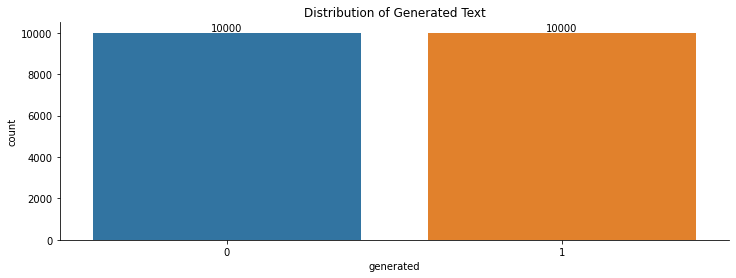

In [49]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=df_train_essays_final,
                   x="generated")


abs_values = df_train_essays_final['generated'].value_counts(sort=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)
ax.set_title("Distribution of Generated Text")

In [50]:
df_train_essays_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       20000 non-null  object
 1   generated  20000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 312.6+ KB


# ❓ 오타수정 library 적용 유무 (24.01.10 : X)

In [51]:
# !pip install pyspellchecker

In [52]:
# from spellchecker import SpellChecker

# spell = SpellChecker()
# misspelled = spell.unknown(['let', 'us', 'wlak', 'on', 'the', 'groun'])

# for word in misspelled:
#     print(f'Misspelled word: {word}')
#     print(f'Suggestion: {spell.correction(word)}')


In [53]:
# !pip install textblob

In [54]:
# from textblob import TextBlob

# text = "I havv goood speling"
# blob = TextBlob(text)

# corrected_text = blob.correct()
# print(corrected_text)

In [55]:
# !pip install hunspell

In [56]:
# import hunspell

# # Hunspell 객체 생성 (사전 파일 필요)
# hun = hunspell.HunSpell('/usr/share/hunspell/en_US.dic', '/usr/share/hunspell/en_US.aff')

# # 스펠 체크
# word = "speling"
# if not hun.spell(word):
#     print(f'Misspelled word: {word}')
#     suggestions = hun.suggest(word)
#     print(f'Suggestions: {suggestions}')

# 🐝 **토큰화 진행 (WordPiece vs BPE)** 

## WordPiece

In [57]:
# max_length 파라미터 조정을 통한 성능 확인

In [58]:
from transformers import RobertaTokenizer
from tqdm.auto import tqdm
import pandas as pd

# BERT 토크나이저 초기화
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# 토큰 길이 계산
token_lengths = []
for text in df_train_essays_final['text']:  # 'text_column'은 텍스트가 포함된 컬럼 이름입니다.
    tokens = tokenizer.encode(text, add_special_tokens=True)
    token_lengths.append(len(tokens))

# 토큰 길이를 DataFrame에 추가
df_train_essays_final['text'] = token_lengths

# 길이 분포 분석
print(df_train_essays_final['text'].describe())

Token indices sequence length is longer than the specified maximum sequence length for this model (567 > 512). Running this sequence through the model will result in indexing errors


count    20000.000000
mean       261.190650
std         73.266316
min         61.000000
25%        213.000000
50%        263.000000
75%        311.000000
max        802.000000
Name: text, dtype: float64


In [59]:

# tqdm을 사용하여 토큰화 진행 상황을 표시
input_ids = []
attention_masks = []

for text in tqdm(df_train_essays_final['text'].tolist(), desc="토큰화 진행중"):
    encoded = tokenizer.encode_plus(text, 
                                    add_special_tokens=True, 
                                    max_length=512, 
                                    padding='max_length', 
                                    truncation=True, 
                                    return_attention_mask=True, 
                                    return_tensors='np')
    input_ids.append(encoded['input_ids'][0])
    attention_masks.append(encoded['attention_mask'][0])

# 토큰화된 데이터를 pandas DataFrame으로 변환
df_encoded = pd.DataFrame({
    'input_ids': input_ids,
    'attention_mask': attention_masks
})



토큰화 진행중:   0%|          | 0/20000 [00:00<?, ?it/s]

ValueError: Input 76 is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.

In [ ]:
df_encoded.to_csv('TF_RoBERTa_encoded_data.csv', index=False)

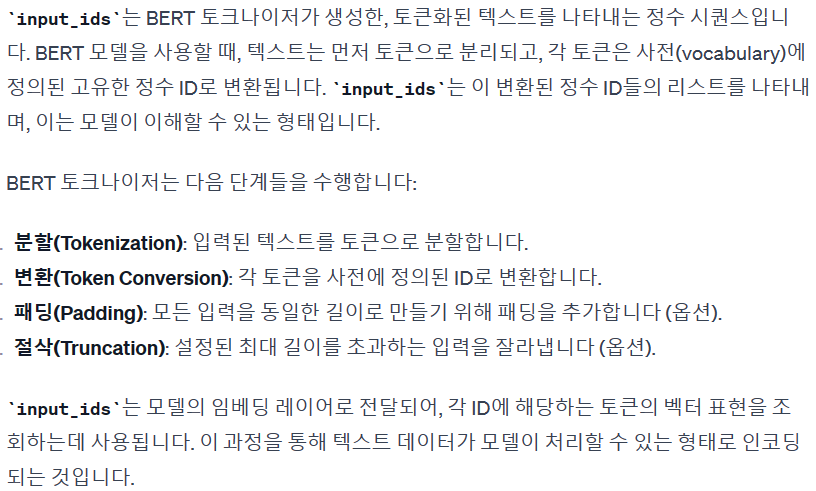

In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# from transformers import BertTokenizer

# # BERT 모델에 대한 기본 tokenizer를 사용합니다.
# bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# # BERT의 tokenizer를 사용하여 텍스트를 토큰화하는 함수를 정의합니다.
# def bert_tokenize(text):
#     # BERT tokenizer로 토큰화하고 토큰 ID를 반환합니다.
#     return bert_tokenizer.encode(text, add_special_tokens=True)

# # TfidfVectorizer 객체를 생성하고, tokenizer로 위에서 정의한 bert_tokenize 함수를 사용합니다.
# tfidf_vectorizer = TfidfVectorizer(tokenizer=bert_tokenize, ngram_range=(1, 2))

# # 트레이닝 데이터에 대해 TF-IDF 벡터화를 수행합니다.
# X_train_tfidf = tfidf_vectorizer.fit_transform(df_train_essays_final['text'])

# # 테스트 데이터에 대해 TF-IDF 벡터화를 수행합니다.
# X_test_tfidf = tfidf_vectorizer.transform(test_essays['text'])

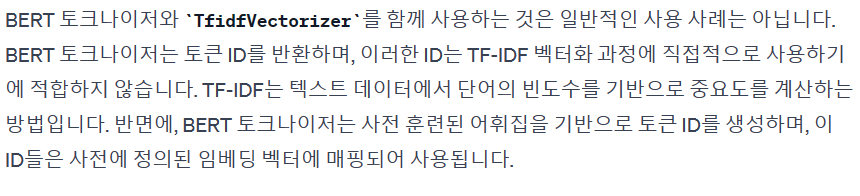

===============================================

## BPE (일단스킵)

In [ ]:
# test_essays.text.values

In [ ]:
# LOWERCASE = False
# VOCAB_SIZE = 30522

In [ ]:
# import sys
# import gc

# import pandas as pd
# from sklearn.model_selection import StratifiedKFold
# import numpy as np
# from sklearn.metrics import roc_auc_score
# import numpy as np

# from sklearn.feature_extraction.text import TfidfVectorizer

# from tokenizers import (
#     decoders,
#     models,
#     normalizers,
#     pre_tokenizers,
#     processors,
#     trainers,
#     Tokenizer,
# )

# from datasets import Dataset
# from tqdm.auto import tqdm
# from transformers import PreTrainedTokenizerFast

# from sklearn.linear_model import SGDClassifier
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.ensemble import VotingClassifier

In [ ]:
# # Creating Byte-Pair Encoding tokenizer
# # 어휘집에 없는 단어는 UNK 토큰화
# raw_tokenizer = Tokenizer(models.BPE(unk_token="[UNK]"))


# # 소문자변환 및 유니코드 문자 정규화, 초기 문자열 byte 수준 분해
# raw_tokenizer.normalizer = normalizers.Sequence([normalizers.NFC()] + [normalizers.Lowercase()] if LOWERCASE else [])
# raw_tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel()


# # train set에 맞는 특수 토크나이징 설정 및 훈련
# # 파라미터, 어휘집크기 30522__일단 지정
# # 
# special_tokens = ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
# trainer = trainers.BpeTrainer(vocab_size=VOCAB_SIZE, special_tokens=special_tokens)



# # df를 huggingface 데이터셋으로 준비, 1000개 단위씩 반복처리
# dataset = Dataset.from_pandas(test_essays[['text']])

# def train_corp_iter():
#     """
#     A generator function for iterating over a dataset in chunks.
#     """    
#     for i in range(0, len(dataset), 1000):
#         yield dataset[i : i + 1000]["text"]

        
        
# # BPE 토크나이저 훈련 진행코드, 특수 토큰도 함께 부여
# raw_tokenizer.train_from_iterator(train_corp_iter(), trainer=trainer)

# tokenizer = PreTrainedTokenizerFast(
#     tokenizer_object=raw_tokenizer,
#     unk_token="[UNK]",
#     pad_token="[PAD]",
#     cls_token="[CLS]",
#     sep_token="[SEP]",
#     mask_token="[MASK]",
# )


# # 토큰화 진행, tqdm으로 진행도 시각화

# tokenized_texts_test = []

# # Tokenize test set with new tokenizer
# for text in tqdm(test_essays['text'].tolist()):
#     tokenized_texts_test.append(tokenizer.tokenize(text))


# # Tokenize train set
# tokenized_texts_train = []

# for text in tqdm(df_train_essays_final['text'].tolist()):
#     tokenized_texts_train.append(tokenizer.tokenize(text))

## BERT 토크나이저 가 아닌
## BPE 토크나이저를 코드에 적용한 이유

###  (wordpiece(BERT기반)와 BPE(GPT기반) 성능 비교)

In [ ]:
# tokenized_texts_test[1]

In [ ]:
# def dummy(text):
#     """
#     A dummy function to use as tokenizer for TfidfVectorizer. It returns the text as it is since we already tokenized it.
#     """
#     return text

In [ ]:
# # Fitting TfidfVectoizer on test set

# vectorizer = TfidfVectorizer(ngram_range=(3, 5), lowercase=False, sublinear_tf=True, analyzer = 'word',
#     tokenizer = dummy,
#     preprocessor = dummy,
#     token_pattern = None, strip_accents='unicode'
#                             )

# vectorizer.fit(tokenized_texts_test)

# # Getting vocab
# vocab = vectorizer.vocabulary_

# print(vocab)


# # Here we fit our vectorizer on train set but this time we use vocabulary from test fit.
# vectorizer = TfidfVectorizer(ngram_range=(3, 5), lowercase=False, sublinear_tf=True, vocabulary=vocab,
#                             analyzer = 'word',
#                             tokenizer = dummy,
#                             preprocessor = dummy,
#                             token_pattern = None, strip_accents='unicode'
#                             )

# tf_train = vectorizer.fit_transform(tokenized_texts_train)
# tf_test = vectorizer.transform(tokenized_texts_test)

# del vectorizer
# gc.collect()

In [ ]:
# y_train = df_train_essays_final['generated'].values

In [ ]:
# tf_train

In [ ]:
# tf_train.shape

In [ ]:
# tf_test.shape

In [ ]:
# pd.DataFrame(tf_train).head

In [ ]:
# dense_tf_train = tf_train.todense()
# df_tf_train = pd.DataFrame(dense_tf_train)
# df_tf_train.describe()

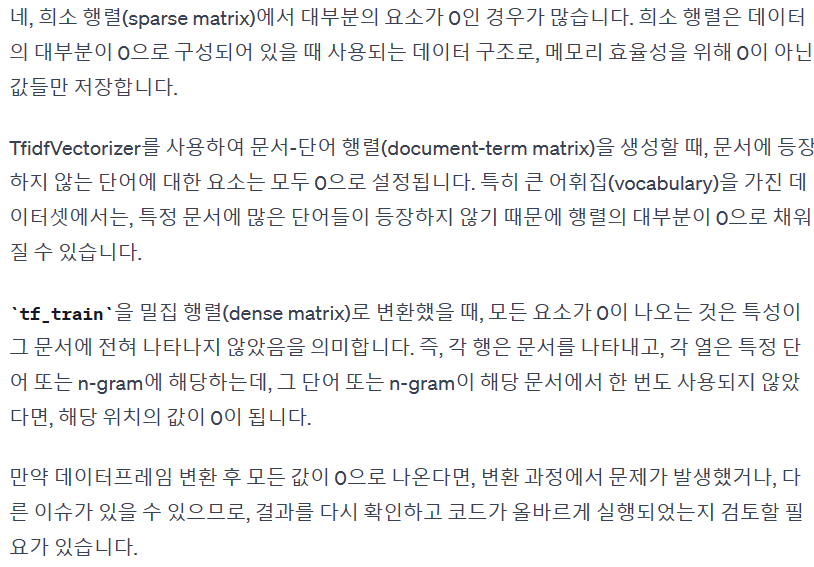

==============================================

# 🐝 **모델학습 진행**

# 🐝 RoBERTa 코드 적용

In [ ]:
# import tensorflow as tf
# from transformers import RobertaTokenizer, TFRobertaForSequenceClassification
# from sklearn.model_selection import train_test_split

# # RoBERTa 토크나이저와 모델 초기화
# tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# model = TFRobertaForSequenceClassification.from_pretrained('roberta-base')

# # 텍스트 데이터 토큰화
# encoded_data = tokenizer(df_train_essays_final['text'].tolist(), 
#                          padding=True, 
#                          truncation=True, 
#                          max_length=128, 
#                          return_tensors='tf')

# input_ids = encoded_data['input_ids']
# attention_masks = encoded_data['attention_mask']

# # 레이블 준비 (여기서는 이진 분류를 가정)
# labels = tf.convert_to_tensor(df_train_essays_final['label'].values)

# # 학습 및 검증 데이터셋 분리
# train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=2018, test_size=0.1)
# train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=2018, test_size=0.1)

# # 데이터셋 준비
# train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_masks, train_labels)).shuffle(100).batch(32)
# validation_dataset = tf.data.Dataset.from_tensor_slices((validation_inputs, validation_masks, validation_labels)).batch(32)

# # 모델 컴파일
# optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08)
# loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# # 모델 학습
# model.fit(train_dataset, epochs=3, validation_data=validation_dataset)


In [ ]:
import pandas as pd

df_encoded = pd.read_csv('TF_RoBERTa_encoded_data.csv')
print(df_encoded.columns)
print()
df_encoded.head()

In [ ]:
# 첫 번째 행의 'input_ids'와 'attention_mask' 열의 데이터 출력
first_row_input_ids = df_encoded['input_ids'].iloc[0]
first_row_attention_mask = df_encoded['attention_mask'].iloc[0]

first_row_input_ids, first_row_attention_mask

In [ ]:
# 문자열을 정수 리스트로 변환하는 함수
def convert_string_to_int_list(string):
    try:
        # 줄바꿈, 대괄호 제거 및 쉼표로 분리
        cleaned_string = string.replace('\n', '').replace('[', '').replace(']', '')
        int_list = [int(i) for i in cleaned_string.split() if i.isdigit()]
        return int_list
    except:
        return []  # 변환에 실패한 경우 빈 리스트 반환

# 데이터프레임의 'input_ids' 열 변환
df_encoded['input_ids'] = df_encoded['input_ids'].apply(convert_string_to_int_list)

# 예시 출력
print(df_encoded.head())

In [ ]:
import tensorflow as tf
from transformers import TFRobertaForSequenceClassification
from sklearn.model_selection import train_test_split

model = TFRobertaForSequenceClassification.from_pretrained('roberta-base')

In [ ]:
# input_ids = tf.convert_to_tensor(df_encoded['input_ids'].values)
# attention_masks = tf.convert_to_tensor(df_encoded['attention_mask'].values)
# labels = tf.convert_to_tensor(df_train_essays_final['generated'].values, dtype=tf.int32)
# # 레이블 데이터

In [ ]:
# 데이터프레임에서 필요한 열만 선택
df_encoded = df_encoded[['input_ids', 'attention_mask']]

# 'generated' 열은 레이블로 사용할 것이므로 따로 선택
labels = df_train_essays_final['generated'].values


In [ ]:
print("df_encoded shape:", df_encoded.shape)
print("labels shape:", labels.shape)

In [ ]:
# 학습 및 검증 데이터셋 분리
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(df_encoded, labels, random_state=2018, test_size=0.1)

# 데이터셋 준비
# train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs.to_dict('list'), train_labels)).shuffle(100).batch(32)
# validation_dataset = tf.data.Dataset.from_tensor_slices((validation_inputs.to_dict('list'), validation_labels)).batch(32)
# 데이터셋 준비
# train_dataset = tf.data.Dataset.from_tensor_slices(({"input_ids": train_inputs['input_ids'], "attention_mask": train_inputs['attention_mask']}, train_labels)).shuffle(100).batch(32)
# validation_dataset = tf.data.Dataset.from_tensor_slices(({"input_ids": validation_inputs['input_ids'], "attention_mask": validation_inputs['attention_mask']}, validation_labels)).batch(32)

In [ ]:
# 데이터셋 준비
train_inputs = {
    "input_ids": np.array(train_inputs["input_ids"].to_list()),
    "attention_mask": np.array(train_inputs["attention_mask"].to_list())
}
train_labels = np.array(train_labels)

validation_inputs = {
    "input_ids": np.array(validation_inputs["input_ids"].to_list()),
    "attention_mask": np.array(validation_inputs["attention_mask"].to_list())
}
validation_labels = np.array(validation_labels)

print("train_inputs shape:", train_inputs["input_ids"].shape)
print("validation_inputs shape:", validation_inputs["input_ids"].shape)
print("train_labels shape:", train_labels.shape)
print("validation_labels shape:", validation_labels.shape)

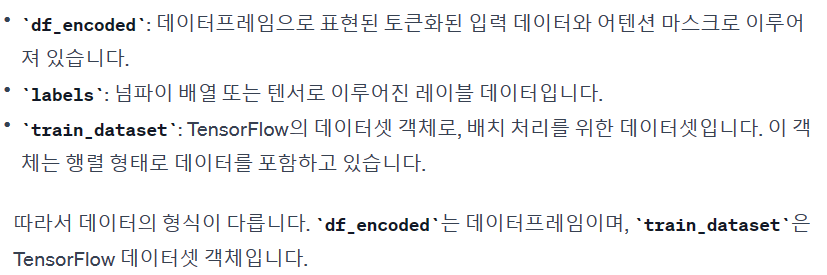

In [ ]:
# 모델 컴파일
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [ ]:
# 문자열을 정수 리스트로 변환하는 함수
def convert_string_to_int_array(string_array):
    int_arrays = []
    for string in string_array:
        # 문자열을 정수 리스트로 변환
        int_list = [int(i) for i in string.split() if i.isdigit()]
        int_arrays.append(int_list)
    return np.array(int_arrays, dtype=int)

# 'attention_mask'의 문자열을 정수 배열로 변환
train_inputs['attention_mask'] = convert_string_to_int_array(train_inputs['attention_mask'])
validation_inputs['attention_mask'] = convert_string_to_int_array(validation_inputs['attention_mask'])

# 변환 후 데이터 타입 재확인
print("After conversion - train_inputs[attention_mask] type:", train_inputs['attention_mask'].dtype)
print("After conversion - validation_inputs[attention_mask] type:", validation_inputs['attention_mask'].dtype)


In [ ]:
# 입력 데이터 형상 확인
print("train_inputs[input_ids] shape:", train_inputs['input_ids'].shape)
print("train_inputs[attention_mask] shape:", train_inputs['attention_mask'].shape)
print("validation_inputs[input_ids] shape:", validation_inputs['input_ids'].shape)
print("validation_inputs[attention_mask] shape:", validation_inputs['attention_mask'].shape)

# 필요한 경우 패딩 또는 트리밍 수행
# 예시: train_inputs['input_ids'] = pad_or_trim(train_inputs['input_ids'], desired_length)

# 모델 학습을 다시 시도


In [ ]:
# attention_mask에 패딩 추가
train_inputs['attention_mask'] = np.pad(train_inputs['attention_mask'], 
                                        ((0, 0), (0, 2)),  # (데이터 시작부터 끝까지, 2개 패딩 추가)
                                        mode='constant',
                                        constant_values=0)

validation_inputs['attention_mask'] = np.pad(validation_inputs['attention_mask'],
                                             ((0, 0), (0, 2)),
                                             mode='constant',
                                             constant_values=0)

# 변환 후 데이터 형상 재확인
print("After padding - train_inputs[attention_mask] shape:", train_inputs['attention_mask'].shape)
print("After padding - validation_inputs[attention_mask] shape:", validation_inputs['attention_mask'].shape)


In [ ]:
# 배치 크기를 줄임
batch_size = 16  # 기존 배치 크기보다 작게 설정

# 모델 학습을 다시 시도
history = model.fit(
    train_inputs,
    train_labels,
    epochs=5,
    batch_size=batch_size,  # 배치 크기 지정
    validation_data=(validation_inputs, validation_labels)
)

In [ ]:
# # model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

# model.train()      #torch 환경에서 진행

# for epoch in range(epochs):  # epochs는 원하는 에포크 수
#     for batch in dataloader:
#         batch = tuple(t.to('cuda') for t in batch)  # device는 'cuda'나 'cpu'
#         b_input_ids, b_input_mask, b_labels = batch

#         # 그래디언트 초기화
#         optimizer.zero_grad()

#         # 순전파
#         outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

#         # 손실값 계산
#         loss = outputs.loss

#         # 역전파
#         loss.backward()

#         # 가중치 업데이트
#         optimizer.step()


# 🐝 RWKV 모델 적용

# 🐝 RAG 모듈 적용

# 🐝 text 데이터 증강기법 __ unbalance 해소

# 🐝 난독화 대처방법 고찰
https://www.kaggle.com/competitions/llm-detect-ai-generated-text/discussion/461292
### 그 중 난독화, 노이즈 대처법 하나
https://www.kaggle.com/code/sjorslockhorst/authentigpt-trial-w-roberta!

# 👿 연습장

In [ ]:
# from transformers import RobertaTokenizer

# # BERT 토크나이저 초기화
# tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# # 텍스트 데이터 토큰화
# # `return_tensors='np'`를 사용하여 NumPy 배열로 반환 받습니다.
# encoded_inputs = tokenizer(df_train_essays_final['text'].tolist(), padding=True, truncation=True, return_tensors='np')

# # 토큰화된 데이터를 pandas DataFrame으로 변환
# df_encoded = pd.DataFrame({
#     'input_ids': encoded_inputs['input_ids'].tolist(),
#     'attention_mask': encoded_inputs['attention_mask'].tolist()
# })

# # DataFrame을 생성한 후, .describe()로 요약 통계를 확인할 수 있습니다.
# df_describe = df_encoded.describe()

# # 요약 통계 출력
# print(df_describe)

In [ ]:
# # We choose 512 because it's the limit of DistilBert
# SEQ_LENGTH = 512

# # Use a shorter sequence length.
# preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(
#     "distil_bert_base_en_uncased",
#     sequence_length=SEQ_LENGTH,
# )

# # Pretrained classifier.
# classifier = keras_nlp.models.DistilBertClassifier.from_preset(
#     "distil_bert_base_en_uncased",
#     num_classes=2,
#     activation=None,
#     preprocessor=preprocessor,
# )

# # Re-compile (e.g., with a new learning rate)
# classifier.compile(
#     loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     optimizer=keras.optimizers.Adam(5e-4),
#     metrics=[
#         keras.metrics.SparseCategoricalAccuracy()
#    ]
# )
    

# # Access backbone programmatically (e.g., to change `trainable`).
# classifier.backbone.trainable = False


# classifier.summary()

In [ ]:
# Split the dataset into train and test sets
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(df_train_essays_final["text"],
                                                    df_train_essays_final["generated"],
                                                    test_size=0.30,
                                                    random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp,
                                                  y_temp,
                                                  test_size=0.20,
                                                  random_state=42)


In [ ]:
# Fit
classifier.fit(x=X_train, 
               y=y_train,
               validation_data=(X_test, y_test),
               epochs=2,
               batch_size=64
              )

In [ ]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Human","AI"],
        cmap=plt.cm.Blues
    )
    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))
    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))

In [ ]:
y_pred_test = classifier.predict(X_test)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
displayConfusionMatrix(y_test, y_pred_test,  "Testing")

In [ ]:
y_pred_val = classifier.predict(X_val)

In [ ]:
displayConfusionMatrix(y_val, y_pred_val,  "validation")